In [1]:
import pandas as pd
import numpy as np
import seaborn as sns



In [2]:
#Let's see where we are..
cd ..

/Users/katybarone/Downloads


In [3]:
#...and move into the correct folder.
cd sb_ca2019_all_csv_v3

/Users/katybarone/Downloads/sb_ca2019_all_csv_v3


In [4]:
#Loading in two datasets from CAASPP Research files. We will merge these later.
df = pd.read_csv('sb_ca2019_all_csv_v3.txt', sep = ',')
entities = pd.read_csv('sb_ca2019entities_csv.txt', sep = ',', encoding = 'ISO-8859-1')

In [5]:
entities.dtypes

County Code        int64
District Code      int64
School Code        int64
Filler           float64
Test Year          int64
Type Id            int64
County Name       object
District Name     object
School Name       object
Zip Code          object
dtype: object

In [6]:
#Every "Test Year" will be 2019, let's remove that column!
entities = entities.drop('Test Year', axis = 1)
print(entities.dtypes)

County Code        int64
District Code      int64
School Code        int64
Filler           float64
Type Id            int64
County Name       object
District Name     object
School Name       object
Zip Code          object
dtype: object


In [59]:
print(df.dtypes)

County Code                            int64
District Code                          int64
School Code                            int64
Filler                               float64
Test Year                              int64
Subgroup ID                            int64
Test Type                             object
Total Tested At Entity Level          object
Total Tested with Scores              object
Grade                                  int64
Test Id                                int64
CAASPP Reported Enrollment            object
Students Tested                       object
Mean Scale Score                      object
Percentage Standard Exceeded          object
Percentage Standard Met               object
Percentage Standard Met and Above     object
Percentage Standard Nearly Met        object
Percentage Standard Not Met           object
Students with Scores                  object
Area 1 Percentage Above Standard      object
Area 1 Percentage Near Standard       object
Area 1 Per

In [ ]:
#It appears that a number of these columns are unecessary for my analysis. 
# I'm going to select only the columns I am interested in below.


In [7]:
df2 = df.iloc[:,0:20].reset_index()

In [8]:
print(df2.dtypes)

index                                  int64
County Code                            int64
District Code                          int64
School Code                            int64
Filler                               float64
Test Year                              int64
Subgroup ID                            int64
Test Type                             object
Total Tested At Entity Level          object
Total Tested with Scores              object
Grade                                  int64
Test Id                                int64
CAASPP Reported Enrollment            object
Students Tested                       object
Mean Scale Score                      object
Percentage Standard Exceeded          object
Percentage Standard Met               object
Percentage Standard Met and Above     object
Percentage Standard Nearly Met        object
Percentage Standard Not Met           object
Students with Scores                  object
dtype: object


In [ ]:
# Many of our columns are of the "object" type. I need them to be numeric so I can perform my analysis.

In [9]:
# Selecting the names of the columns from df2 that I want to make numeric
cols_to_numeric = ['Test Id', 
                   'CAASPP Reported Enrollment',
                   'Students Tested',
                   'Mean Scale Score',
                   'Percentage Standard Exceeded',
                   'Percentage Standard Met',
                   'Percentage Standard Met and Above',
                   'Percentage Standard Nearly Met',
                   'Percentage Standard Not Met',
                   'Students with Scores']


In [10]:
# Looping through the list of column names to transform the type from object to numeric.
# Null values in this dataframe show up as "*"s. Coercing the errors changes them to NaNs.
for col in cols_to_numeric:
    df2[col] = pd.to_numeric(df2[col], errors = 'coerce')
print(df2.dtypes)

index                                  int64
County Code                            int64
District Code                          int64
School Code                            int64
Filler                               float64
Test Year                              int64
Subgroup ID                            int64
Test Type                             object
Total Tested At Entity Level          object
Total Tested with Scores              object
Grade                                  int64
Test Id                                int64
CAASPP Reported Enrollment           float64
Students Tested                      float64
Mean Scale Score                     float64
Percentage Standard Exceeded         float64
Percentage Standard Met              float64
Percentage Standard Met and Above    float64
Percentage Standard Nearly Met       float64
Percentage Standard Not Met          float64
Students with Scores                 float64
dtype: object


In [ ]:
# MAKE THESE MORE ELEGANT
# Want to separate out the grade level data, as well as the county and district data.
# What we want is a list of school site level data broken out by subgroup.

In [11]:
grades_sep = df2[df2['Grade']!= 13]

In [12]:
df4 = df2[df2['Grade']==13]

In [13]:
df4 = df4[df4['County Code'] != 0]

In [14]:
df4 = df4[df4['District Code']!=0]

In [15]:
df4 = df4[df4['School Code'] != 0]

In [16]:
df4.head()

,index,County Code,District Code,School Code,Filler,Test Year,Subgroup ID,Test Type,Total Tested At Entity Level,Total Tested with Scores,...,Test Id,CAASPP Reported Enrollment,Students Tested,Mean Scale Score,Percentage Standard Exceeded,Percentage Standard Met,Percentage Standard Met and Above,Percentage Standard Nearly Met,Percentage Standard Not Met,Students with Scores
1927,1927,1,10017,112607,NaN,2019,1,B,85,84,...,1,90.0,85.0,NaN,7.14,27.38,34.52,36.90,28.57,84.0
1928,1928,1,10017,112607,NaN,2019,3,B,42,42,...,1,43.0,42.0,NaN,9.52,21.43,30.95,40.48,28.57,42.0
1929,1929,1,10017,112607,NaN,2019,4,B,43,42,...,1,47.0,43.0,NaN,4.76,33.33,38.10,33.33,28.57,42.0
1930,1930,1,10017,112607,NaN,2019,6,B,79,78,...,1,83.0,79.0,NaN,7.69,29.49,37.18,38.46,24.36,78.0
1931,1931,1,10017,112607,NaN,2019,7,B,*,*,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# There are two different tests that make up this dataframe. "Test Id" ==2 and "Test Id" ==1. 
# "Test ID" ==2 is the SBAC Math test. "Test Id" ==1 if the SBAC ELA test.
# I'd like to break these out into two separate datasets.
math = df4[df4['Test Id']==2]
ela = df4[df4['Test Id'] ==1]
math.head()

,index,County Code,District Code,School Code,Filler,Test Year,Subgroup ID,Test Type,Total Tested At Entity Level,Total Tested with Scores,...,Test Id,CAASPP Reported Enrollment,Students Tested,Mean Scale Score,Percentage Standard Exceeded,Percentage Standard Met,Percentage Standard Met and Above,Percentage Standard Nearly Met,Percentage Standard Not Met,Students with Scores
2005,2005,1,10017,112607,NaN,2019,1,B,84,84,...,2,90.0,84.0,NaN,3.57,7.14,10.71,16.67,72.62,84.0
2006,2006,1,10017,112607,NaN,2019,3,B,41,41,...,2,43.0,41.0,NaN,4.88,9.76,14.63,14.63,70.73,41.0
2007,2007,1,10017,112607,NaN,2019,4,B,43,43,...,2,47.0,43.0,NaN,2.33,4.65,6.98,18.60,74.42,43.0
2008,2008,1,10017,112607,NaN,2019,6,B,78,78,...,2,83.0,78.0,NaN,3.85,7.69,11.54,17.95,70.51,78.0
2009,2009,1,10017,112607,NaN,2019,7,B,*,*,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# There should be about the same amount of data in each dataset. Let's check.

In [18]:
print((len(math),len(ela)))

(398816, 398815)


In [ ]:
# Merging our main dataset with the "entites" dataset. 
# This adds in school level data like school name, zip code and school type.

In [20]:
math = math.merge(entities, how = 'left', on = 'School Code')
ela = ela.merge(entities, how = 'left', on = 'School Code')

In [45]:
print(math.columns)

Index(['index', 'County Code_x', 'District Code_x', 'School Code', 'Filler_x',
       'Test Year', 'Subgroup ID', 'Test Type', 'Total Tested At Entity Level',
       'Total Tested with Scores', 'Grade', 'Test Id',
       'CAASPP Reported Enrollment', 'Students Tested', 'Mean Scale Score',
       'Percentage Standard Exceeded', 'Percentage Standard Met',
       'Percentage Standard Met and Above', 'Percentage Standard Nearly Met',
       'Percentage Standard Not Met', 'Students with Scores', 'County Code_y',
       'District Code_y', 'Filler_y', 'Type Id', 'County Name',
       'District Name', 'School Name', 'Zip Code'],
      dtype='object')


In [ ]:
# Interested in 

In [70]:
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt


math_hs_grad = math[math['Subgroup ID']== 91]
math_no_grad = math[math['Subgroup ID'] ==90]
math_hs_grad = math_hs_grad['Percentage Standard Met and Above']
math_no_grad = math_no_grad['Percentage Standard Met and Above']


math_grad_mean = np.mean(math_hs_grad)
math_no_grad_mean = np.mean(math_no_grad)
math_grad_std = np.std(math_hs_grad)
math_no_grad_std = np.std(math_no_grad)

print(math_no_grad_mean, math_grad_mean)

21.859467353951832 27.894322476379916


In [67]:
math_hs_grad2 = math_hs_grad.fillna(math_grad_mean)
math_no_grad2 = math_no_grad.fillna(math_no_grad_mean)


In [68]:
tstat, pval = ttest_ind(math_hs_grad2, math_no_grad2)
print(pval)

8.243457355917089e-235


In [ ]:
parents = math_hs_grad[math_hs_grad]

In [72]:
print(math_no_grad.isna().sum())

2967


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


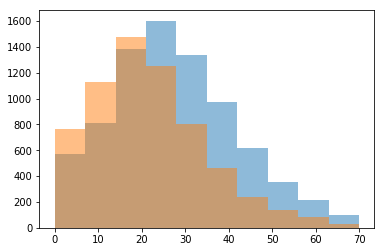

In [73]:
plt.hist(math_hs_grad, range = (0,70), alpha = 0.5)
plt.hist(math_no_grad, range = (0,70), alpha = 0.5)
plt.show()

In [22]:
envision = math[math['School Code'] == 112607]

In [23]:
print(len(envision))

39


In [24]:
envision = envision.drop('School Code', axis = 1)
envision = envision.rename(columns = {'CAASPP Reported Enrollment':'Enrolled',
                                     'Percentage Standard Exceeded': 'Exceeded',
                                      'Percentage Standard Met': 'Met',
                                     'Percentage Standard Met and Above':'Met_and_Above',
                                      'Percentage Standard Nearly Met': 'Nearly_Met',
                                      'Percentage Standard Not Met': 'Not_Met',
                                      'County Code_x': 'County Code',
                                      'District Code_x': 'District Code'
                                     })
print(envision.columns)

Index(['index', 'County Code', 'District Code', 'Filler_x', 'Test Year',
       'Subgroup ID', 'Test Type', 'Total Tested At Entity Level',
       'Total Tested with Scores', 'Grade', 'Test Id', 'Enrolled',
       'Students Tested', 'Mean Scale Score', 'Exceeded', 'Met',
       'Met_and_Above', 'Nearly_Met', 'Not_Met', 'Students with Scores',
       'County Code_y', 'District Code_y', 'Filler_y', 'Type Id',
       'County Name', 'District Name', 'School Name', 'Zip Code'],
      dtype='object')


In [41]:
envision = envision.drop('Grade', axis = 1)
envision

,Subgroup ID,Total Tested At Entity Level,Total Tested with Scores,Test Id,Enrolled,Students Tested,Mean Scale Score,Exceeded,Met,Met_and_Above,...,Not_Met,Students with Scores,County Code_y,District Code_y,Filler_y,Type Id,County Name,District Name,School Name,Zip Code
0,1,84,84,2,90.0,84.0,NaN,3.57,7.14,10.71,...,72.62,84.0,1,10017,NaN,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
1,3,41,41,2,43.0,41.0,NaN,4.88,9.76,14.63,...,70.73,41.0,1,10017,NaN,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
2,4,43,43,2,47.0,43.0,NaN,2.33,4.65,6.98,...,74.42,43.0,1,10017,NaN,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
3,6,78,78,2,83.0,78.0,NaN,3.85,7.69,11.54,...,70.51,78.0,1,10017,NaN,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
4,7,*,*,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,10017,NaN,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
5,8,38,38,2,38.0,38.0,NaN,7.89,5.26,13.16,...,65.79,38.0,1,10017,NaN,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
6,31,67,67,2,69.0,67.0,NaN,2.99,8.96,11.94,...,71.64,67.0,1,10017,NaN,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
7,51,84,84,2,90.0,84.0,NaN,3.57,7.14,10.71,...,72.62,84.0,1,10017,NaN,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
8,53,84,84,2,90.0,84.0,NaN,3.57,7.14,10.71,...,72.62,84.0,1,10017,NaN,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
9,74,29,29,2,34.0,29.0,NaN,0.00,3.45,3.45,...,86.21,29.0,1,10017,NaN,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612


In [31]:
from scipy.stats import ttest_ind


env_hs_grad = envision[envision['Subgroup ID']== 91]
env_no_grad = envision[envision['Subgroup ID'] ==90]
env_hs_grad = env_hs_grad['Met_and_Above']
env_no_grad = env_no_grad['Met_and_Above']


grad_mean = np.mean(env_hs_grad)
no_grad_mean = np.mean(env_no_grad)
grad_std = np.std(env_hs_grad)
no_grad_std = np.std(env_no_grad)

print(no_grad_mean)

21.74


In [ ]:
print(math.columns)

In [ ]:
# pd.to_numeric(df2[['CAASPP Reported Enrollment','Students Tested','Mean Scale Score','Percentage Standard Exceeded','Percentage Standard Met','Percentage Standard Met and Above','Percentage Standard Nearly Met','Percentage Standard Not Met','Students with Scores']], errors = 'coerce')